In [1]:
import pathlib

import anndata
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
from ALLCools.integration import calculate_overlap_score, confusion_matrix_clustering
from ALLCools.mcds import MCDS
from ALLCools.plot import *
from wmb import aibs, brain, cemba

In [2]:
dataset = "AIBS_TENX"
mc_cat_key = "L4Region"
rna_cat_key = "L3"

In [3]:
# Parameters
cpu = 1
dataset = "AIBS_TENX"
group_name = "CorticalExc"
mc_cat_key = "L4Region"
mem_gb = 1
rna_cat_key = "L3"

## Load

In [4]:
mc_annot = cemba.get_mc_annot()

L4_annot does not exist in data_vars or coords, palette not added.


In [5]:
if dataset == "AIBS_SMART":
    rna_annot = aibs.get_smart_annot()
elif dataset == "AIBS_TENX":
    rna_annot = aibs.get_tenx_annot()
else:
    raise ValueError

In [6]:
mc_cluster = mc_annot[mc_cat_key].to_pandas()
rna_cluster = rna_annot[rna_cat_key].to_pandas()

In [7]:
adata_merge = anndata.read_h5ad("final_with_coords.h5ad")

In [8]:
adata_merge

AnnData object with n_obs × n_vars = 1536223 × 6231
    obs: 'count', 'umi_count', 'n_counts', 'Modality', 'L2', 'DissectionRegion', 'leiden'
    var: 'chrom', 'name-RNA', 'start-RNA', 'end-RNA', 'mean-RNA', 'std-RNA', 'start-mC', 'end-mC', 'cov_mean-mC', 'cef-mC'
    uns: 'leiden', 'leiden_sizes', 'neighbors', 'paga', 'umap'
    obsm: 'X_harmony', 'X_pca_integrate', 'X_tsne', 'X_umap'
    obsp: 'connectivities', 'distances'

In [9]:
rna_meta = adata_merge.obs[adata_merge.obs["Modality"] == "RNA"].copy()
mc_meta = adata_merge.obs[adata_merge.obs["Modality"] == "mC"].copy()

## Confusion Matrix Based On Co-clustering Overlap Score

In [10]:
rna_meta[rna_cat_key] = rna_annot[rna_cat_key].to_pandas()
mc_meta[mc_cat_key] = mc_annot[mc_cat_key].to_pandas()
os_mat = calculate_overlap_score(
    rna_meta[[rna_cat_key, "leiden"]], mc_meta[[mc_cat_key, "leiden"]]
)
os_mat.to_hdf(f"RNA-{rna_cat_key}.mC-{mc_cat_key}.overlap_score.hdf", key="data")

## Confusion Matrix Clustering

In [11]:
(
    query_group,
    ref_group,
    confusion_matrix,
    g,
    modularity_score,
) = confusion_matrix_clustering(
    confusion_matrix=os_mat,
    min_value=0.1,
    max_value=0.9,
    partition_type=None,
    resolution=1,
    seed=0,
)
print(f"Modularity: {modularity_score:.3f}")

Modularity: 0.847


<AxesSubplot:>

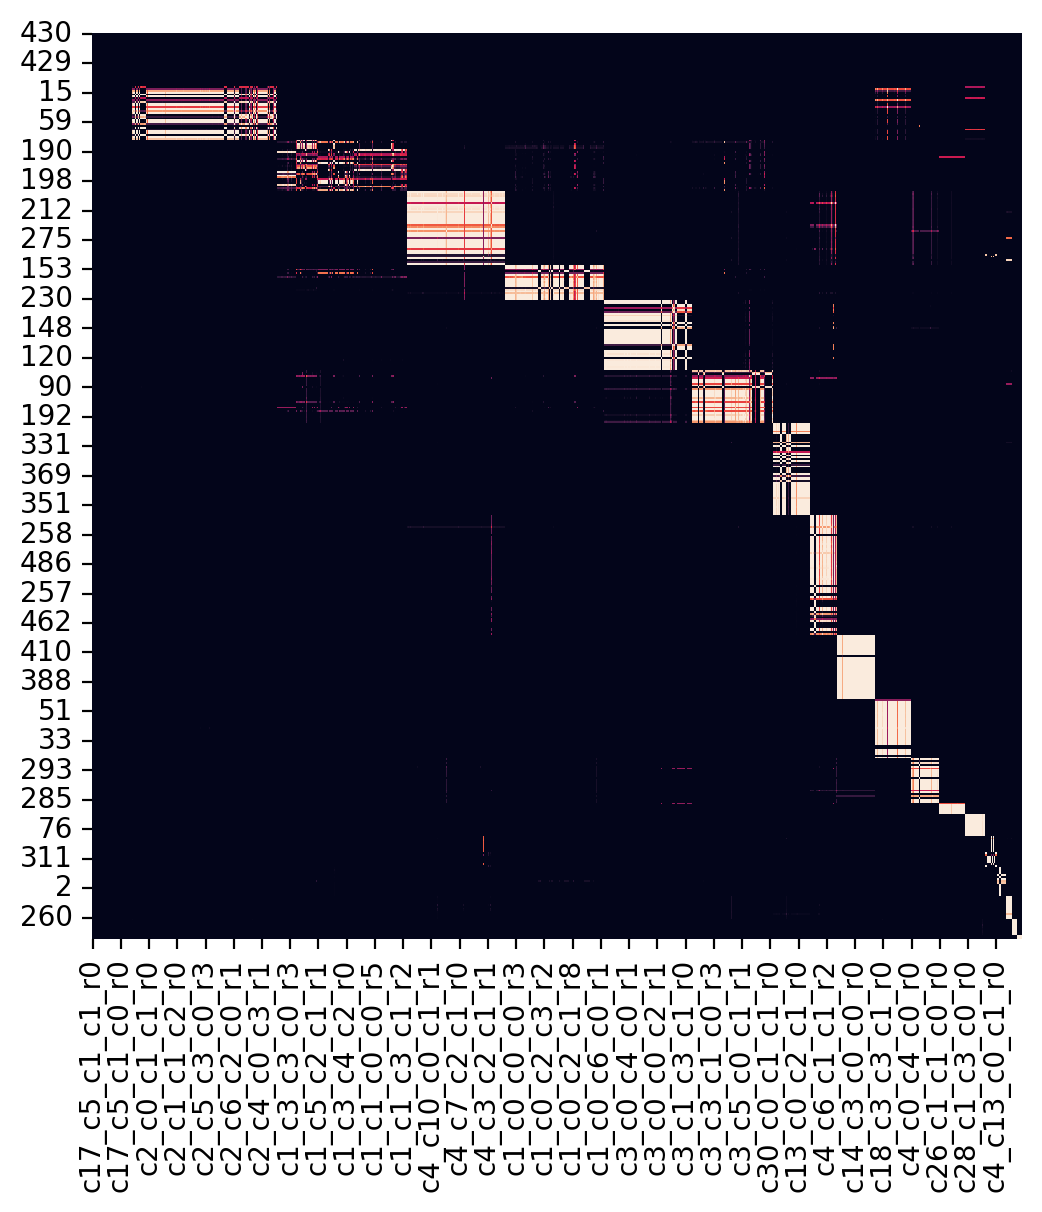

In [12]:
fig, ax = plt.subplots(figsize=(6, 6), dpi=200)
sns.heatmap(confusion_matrix, ax=ax, vmin=0.1, vmax=0.9, cbar=None)

In [23]:
# combine query into ref groups, ref is non-dup, query maybe dup
integration_groups = {}
for group, sub_matrix in confusion_matrix.groupby(ref_group, axis=1):
    use_ref_group = ref_group[ref_group == group].index
    use_query = (sub_matrix.max(axis=1) > 0.5) | (sub_matrix.mean(axis=1) > 0.3)
    use_query_group = use_query[use_query].index
    integration_groups[group] = {
        "ref": use_ref_group.tolist(),
        "query": use_query_group.tolist(),
    }

In [24]:
all_rna_clusters = []
for group, group_dict in integration_groups.items():
    all_rna_clusters += group_dict["query"]
all_rna_clusters = set(all_rna_clusters)

if -1 in integration_groups:
    integration_groups[-1]["query"] = []
    for c in confusion_matrix.index:
        if c not in all_rna_clusters:
            integration_groups[-1]["query"].append(c)
    print(integration_groups[-1])

{'ref': ['c13_c3_c2_c0_r0', 'c17_c0_c0_c0_r0', 'c17_c0_c0_c0_r1', 'c17_c0_c0_c0_r2', 'c17_c0_c0_c0_r3', 'c17_c0_c0_c0_r4', 'c17_c0_c0_c1_r0', 'c17_c0_c0_c1_r1', 'c17_c0_c0_c1_r2', 'c17_c0_c0_c2_r0', 'c17_c0_c1_c0_r0', 'c17_c0_c1_c0_r1', 'c17_c0_c1_c1_r0', 'c17_c0_c1_c1_r1', 'c17_c0_c2_c0_r0', 'c17_c0_c2_c0_r1', 'c17_c0_c2_c1_r0', 'c17_c0_c2_c1_r1', 'c17_c1_c0_c0_r0', 'c17_c1_c0_c1_r0', 'c17_c1_c1_c0_r0', 'c17_c1_c1_c1_r0', 'c17_c1_c2_c0_r0', 'c17_c1_c2_c0_r1', 'c17_c1_c2_c1_r0', 'c17_c2_c0_c0_r0', 'c17_c2_c0_c0_r1', 'c17_c2_c0_c1_r0', 'c17_c2_c0_c1_r1', 'c17_c2_c0_c2_r0', 'c17_c2_c0_c3_r0', 'c17_c2_c1_c0_r0', 'c17_c2_c1_c0_r1', 'c17_c2_c1_c0_r2', 'c17_c2_c1_c1_r0', 'c17_c3_c0_c0_r0', 'c17_c3_c0_c0_r1', 'c17_c3_c0_c0_r2', 'c17_c3_c0_c0_r3', 'c17_c3_c0_c1_r0', 'c17_c3_c1_c0_r0', 'c17_c3_c1_c0_r1', 'c17_c3_c1_c0_r2', 'c17_c3_c2_c0_r0', 'c17_c3_c2_c0_r1', 'c17_c3_c2_c1_r0', 'c17_c4_c0_c0_r0', 'c17_c4_c0_c1_r0', 'c17_c4_c0_c1_r1', 'c17_c4_c0_c2_r0', 'c17_c4_c0_c2_r1', 'c17_c4_c1_c0_r0', 'c1

In [25]:
rna_to_annot = pd.Series(
    rna_annot["L2_annot"].values, index=rna_annot["L3"].values
).to_dict()
mc_to_annot = pd.Series(
    mc_annot["L1_annot"].values, index=mc_annot["L4Region"].values
).to_dict()

In [26]:
# manual assign
manual_group = {
    "ref": {
        "c13_c3_c2_c0_r0": 6,
        "c17_c0_c0_c0_r0": 6,
        "c17_c0_c0_c0_r1": 6,
        "c17_c0_c0_c0_r2": 6,
        "c17_c0_c0_c0_r3": 6,
        "c17_c0_c0_c0_r4": 6,
        "c17_c0_c0_c1_r0": 6,
        "c17_c0_c0_c1_r1": 6,
        "c17_c0_c0_c1_r2": 6,
        "c17_c0_c0_c2_r0": 6,
        "c17_c0_c1_c0_r0": 6,
        "c17_c0_c1_c0_r1": 6,
        "c17_c0_c1_c1_r0": 6,
        "c17_c0_c1_c1_r1": 6,
        "c17_c0_c2_c0_r0": 6,
        "c17_c0_c2_c0_r1": 6,
        "c17_c0_c2_c1_r0": 6,
        "c17_c0_c2_c1_r1": 6,
        "c17_c1_c0_c0_r0": 6,
        "c17_c1_c0_c1_r0": 6,
        "c17_c1_c1_c0_r0": 6,
        "c17_c1_c1_c1_r0": 6,
        "c17_c1_c2_c0_r0": 6,
        "c17_c1_c2_c0_r1": 6,
        "c17_c1_c2_c1_r0": 6,
        "c17_c2_c0_c0_r0": 6,
        "c17_c2_c0_c0_r1": 6,
        "c17_c2_c0_c1_r0": 6,
        "c17_c2_c0_c1_r1": 6,
        "c17_c2_c0_c2_r0": 6,
        "c17_c2_c0_c3_r0": 6,
        "c17_c2_c1_c0_r0": 6,
        "c17_c2_c1_c0_r1": 6,
        "c17_c2_c1_c0_r2": 6,
        "c17_c2_c1_c1_r0": 6,
        "c17_c3_c0_c0_r0": 6,
        "c17_c3_c0_c0_r1": 6,
        "c17_c3_c0_c0_r2": 6,
        "c17_c3_c0_c0_r3": 6,
        "c17_c3_c0_c1_r0": 6,
        "c17_c3_c1_c0_r0": 6,
        "c17_c3_c1_c0_r1": 6,
        "c17_c3_c1_c0_r2": 6,
        "c17_c3_c2_c0_r0": 6,
        "c17_c3_c2_c0_r1": 6,
        "c17_c3_c2_c1_r0": 6,
        "c17_c4_c0_c0_r0": 6,
        "c17_c4_c0_c1_r0": 6,
        "c17_c4_c0_c1_r1": 6,
        "c17_c4_c0_c2_r0": 6,
        "c17_c4_c0_c2_r1": 6,
        "c17_c4_c1_c0_r0": 6,
        "c17_c4_c1_c0_r1": 6,
        "c17_c4_c1_c1_r0": 6,
        "c17_c4_c1_c2_r0": 6,
        "c17_c5_c0_c0_r0": 6,
        "c17_c5_c0_c0_r1": 6,
        "c17_c5_c0_c1_r0": 6,
        "c17_c5_c0_c2_r0": 6,
        "c17_c5_c0_c3_r0": 6,
        "c17_c5_c1_c0_r0": 6,
        "c17_c5_c1_c0_r1": 6,
        "c17_c5_c1_c1_r0": 6,
        "c17_c6_c0_c0_r0": 6,
        "c17_c6_c1_c1_r0": 6,
        "c17_c6_c2_c2_r0": 6,
        "c17_c6_c2_c2_r1": 6,
        "c17_c6_c3_c3_r0": 6,
        "c17_c6_c4_c4_r0": 6,
        "c17_c7_c0_c0_r0": 6,
        "c17_c7_c0_c1_r0": 6,
        "c17_c7_c1_c1_r0": 6,
        "c17_c8_c0_c0_r0": 6,
        "c17_c8_c0_c0_r1": 6,
        "c17_c8_c1_c1_r0": 6,
        "c17_c8_c2_c2_r0": 6,
        "c17_c9_c0_c0_r0": 6,
        "c17_c9_c1_c1_r0": 6,
        "c18_c7_c0_c0_r0": 9,
        "c18_c7_c1_c1_r0": 9,
        "c18_c7_c2_c2_r0": 9,
        "c18_c7_c3_c3_r0": 9,
    },
    "query": {
        "430": 6,
        "428": 6,
        "427": 6,
        "426": 6,
        "425": 6,
        "424": 6,
        "423": 6,
        "422": 6,
        "421": 6,
        "420": 6,
        "419": 6,
        "418": 6,
        "417": 6,
        "416": 6,
        "415": 6,
        "414": 6,
        "429": 6,
        "431": 6,
        "1339": 2,
        "1408": 2,
        "433": 6,
        "434": 6,
        "435": 6,
        "1363": 2,
        "1372": 2,
        "432": 6,
        "278": 6,
        "297": 6,
        "1340": 2,
        "436": 6,
        "1406": 2,
        "1371": 2,
    },
}
for k, v in manual_group["ref"].items():
    integration_groups[v]["ref"].append(k)
for k, v in manual_group["query"].items():
    integration_groups[v]["query"].append(k)

In [28]:
for group, group_dict in integration_groups.items():
    print(group)
    print(f'ref: {", ".join(group_dict["ref"])}')
    print(f'query: {", ".join(group_dict["query"])}')
    print()

-1
ref: c13_c3_c2_c0_r0, c17_c0_c0_c0_r0, c17_c0_c0_c0_r1, c17_c0_c0_c0_r2, c17_c0_c0_c0_r3, c17_c0_c0_c0_r4, c17_c0_c0_c1_r0, c17_c0_c0_c1_r1, c17_c0_c0_c1_r2, c17_c0_c0_c2_r0, c17_c0_c1_c0_r0, c17_c0_c1_c0_r1, c17_c0_c1_c1_r0, c17_c0_c1_c1_r1, c17_c0_c2_c0_r0, c17_c0_c2_c0_r1, c17_c0_c2_c1_r0, c17_c0_c2_c1_r1, c17_c1_c0_c0_r0, c17_c1_c0_c1_r0, c17_c1_c1_c0_r0, c17_c1_c1_c1_r0, c17_c1_c2_c0_r0, c17_c1_c2_c0_r1, c17_c1_c2_c1_r0, c17_c2_c0_c0_r0, c17_c2_c0_c0_r1, c17_c2_c0_c1_r0, c17_c2_c0_c1_r1, c17_c2_c0_c2_r0, c17_c2_c0_c3_r0, c17_c2_c1_c0_r0, c17_c2_c1_c0_r1, c17_c2_c1_c0_r2, c17_c2_c1_c1_r0, c17_c3_c0_c0_r0, c17_c3_c0_c0_r1, c17_c3_c0_c0_r2, c17_c3_c0_c0_r3, c17_c3_c0_c1_r0, c17_c3_c1_c0_r0, c17_c3_c1_c0_r1, c17_c3_c1_c0_r2, c17_c3_c2_c0_r0, c17_c3_c2_c0_r1, c17_c3_c2_c1_r0, c17_c4_c0_c0_r0, c17_c4_c0_c1_r0, c17_c4_c0_c1_r1, c17_c4_c0_c2_r0, c17_c4_c0_c2_r1, c17_c4_c1_c0_r0, c17_c4_c1_c0_r1, c17_c4_c1_c1_r0, c17_c4_c1_c2_r0, c17_c5_c0_c0_r0, c17_c5_c0_c0_r1, c17_c5_c0_c1_r0, c17_c5

In [29]:
ref_counts = []
for k, v in integration_groups.items():
    if k == -1:
        continue
    ref_counts += v["ref"]
# ref group may not duplicate
assert pd.Series(ref_counts).value_counts().max() == 1

query_counts = []
for k, v in integration_groups.items():
    query_counts += v["query"]
# query group may be duplicate
counts = pd.Series(query_counts).value_counts()
counts[counts > 1]

154    3
152    3
265    3
182    3
181    3
      ..
76     2
89     2
87     2
78     2
166    2
Length: 168, dtype: int64

-1
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17


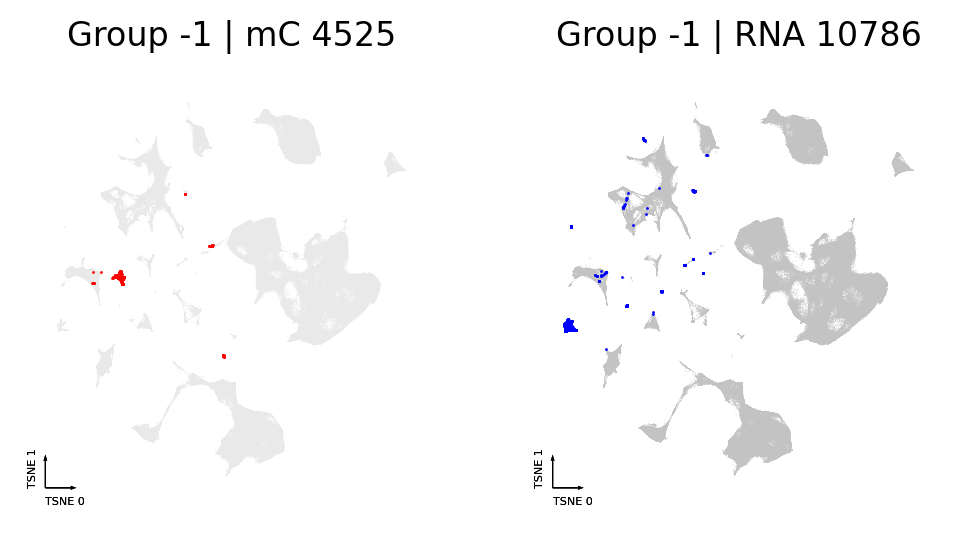

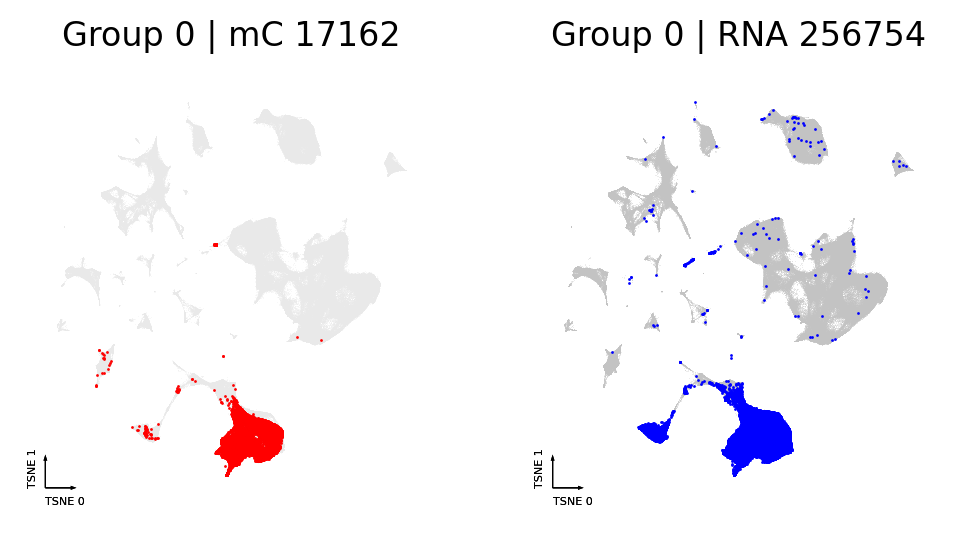

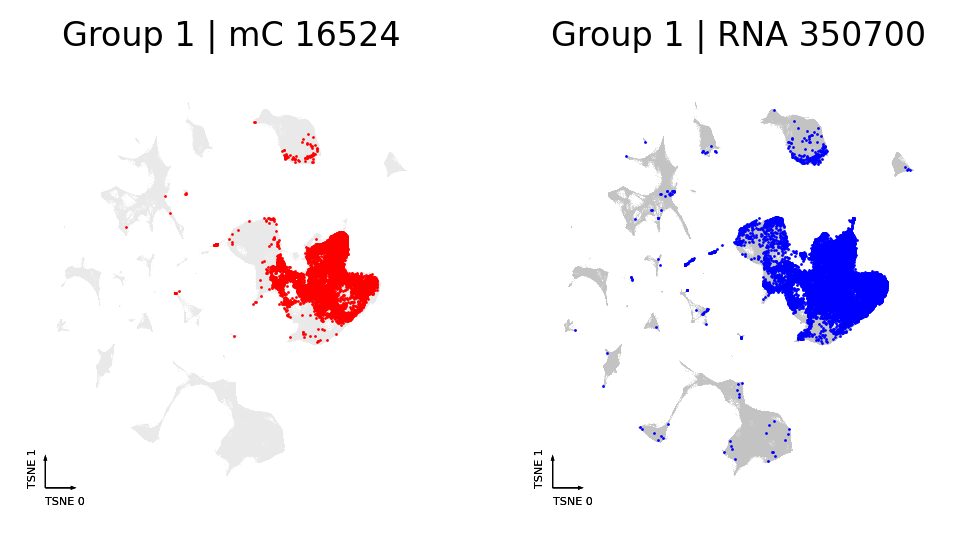

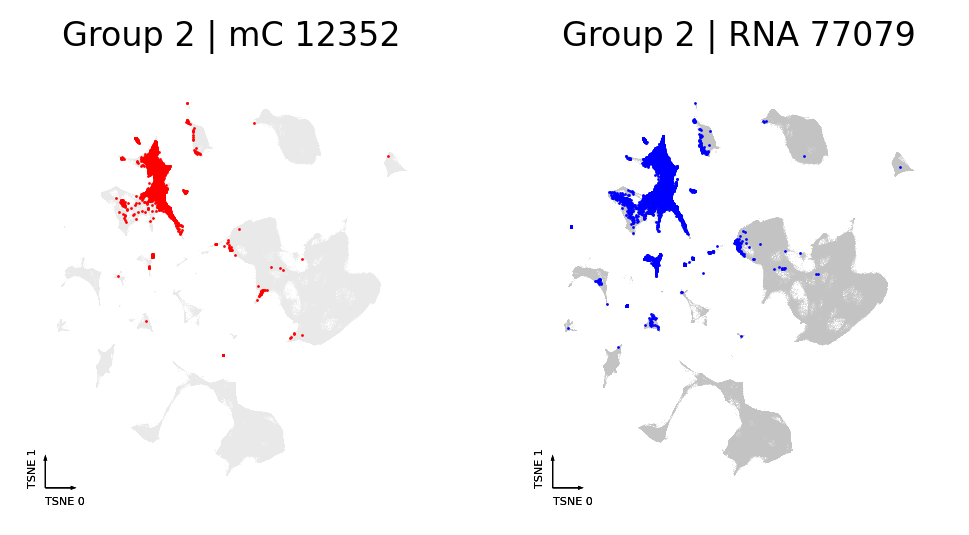

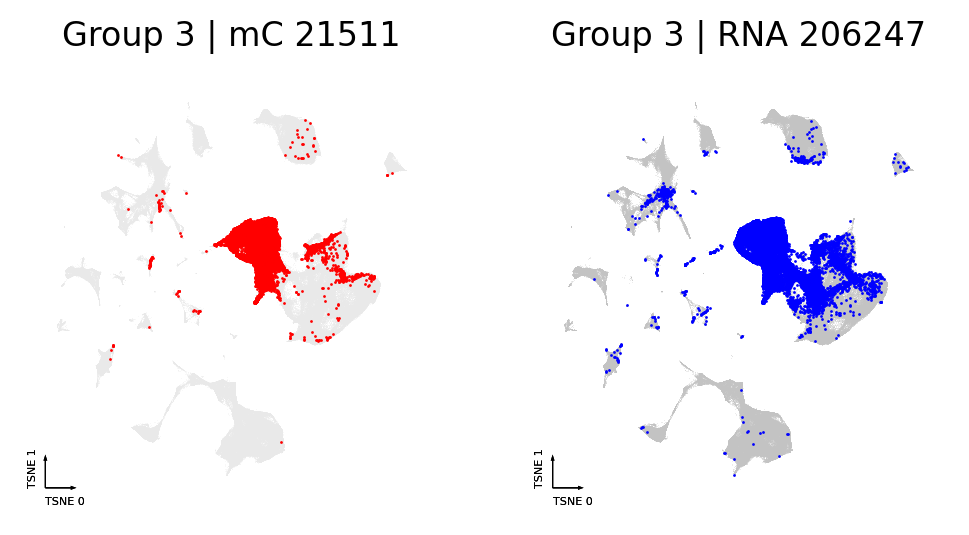

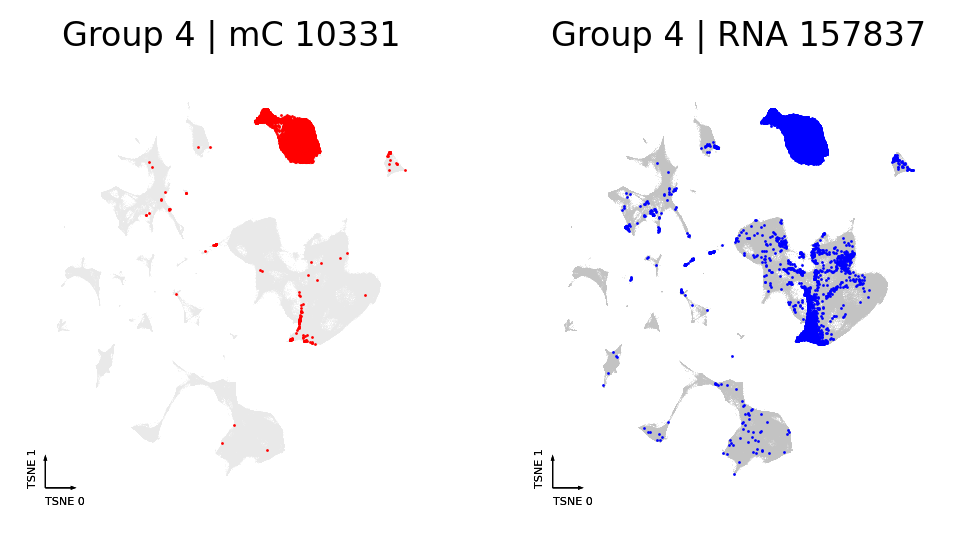

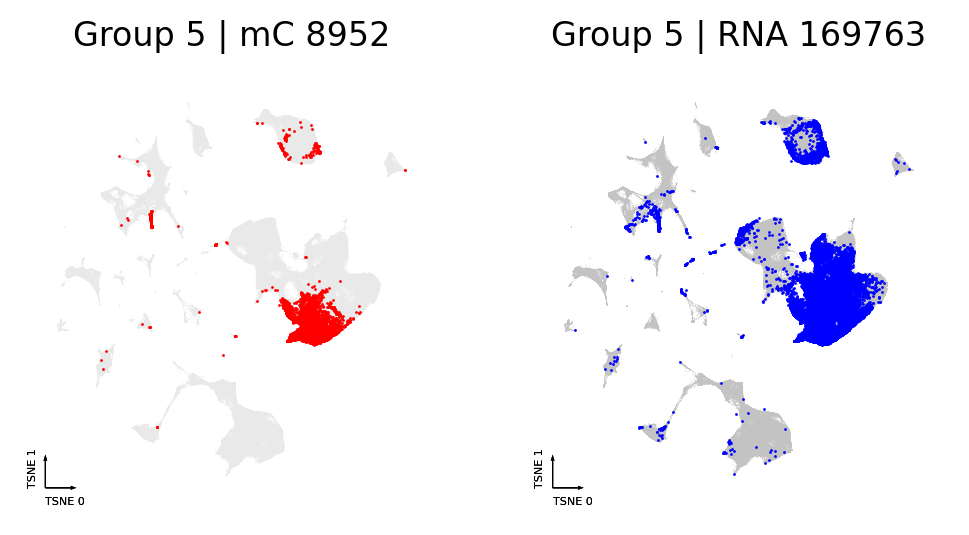

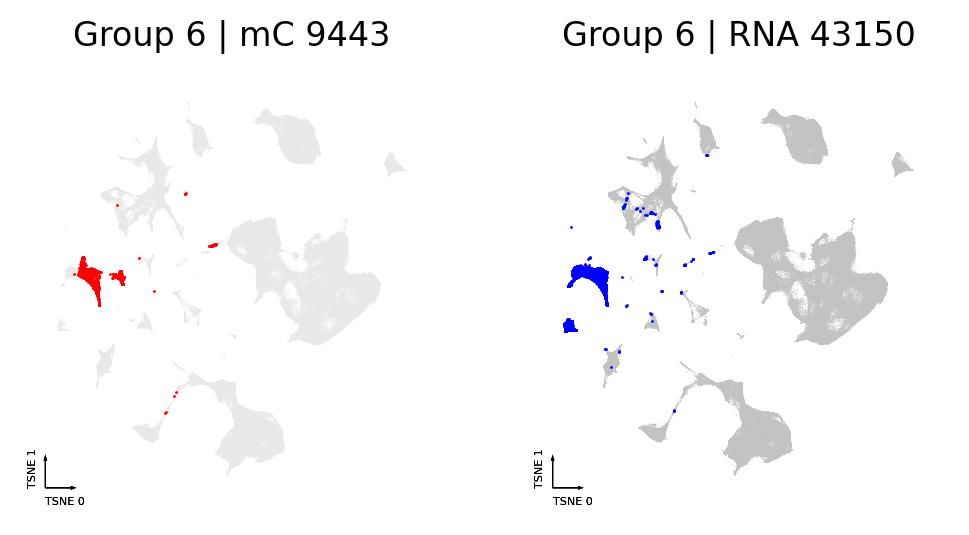

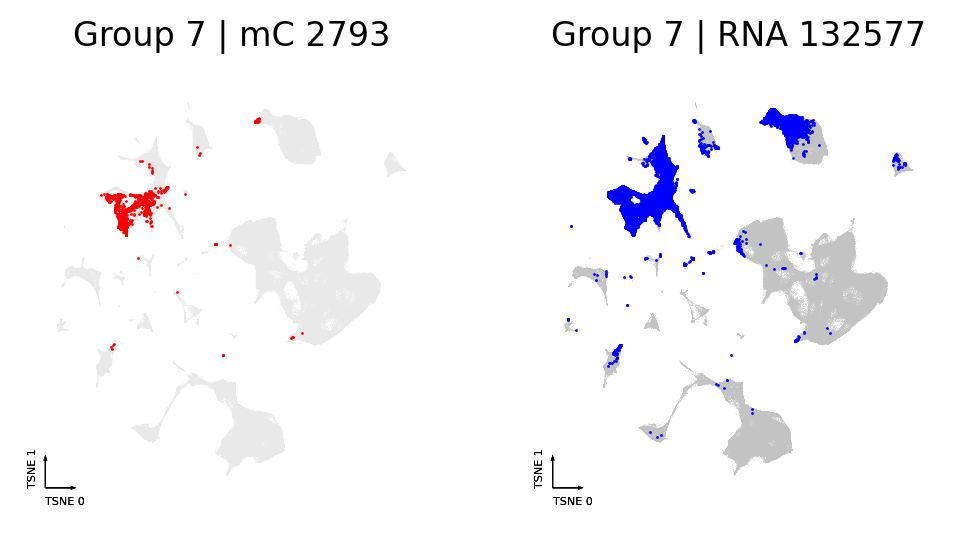

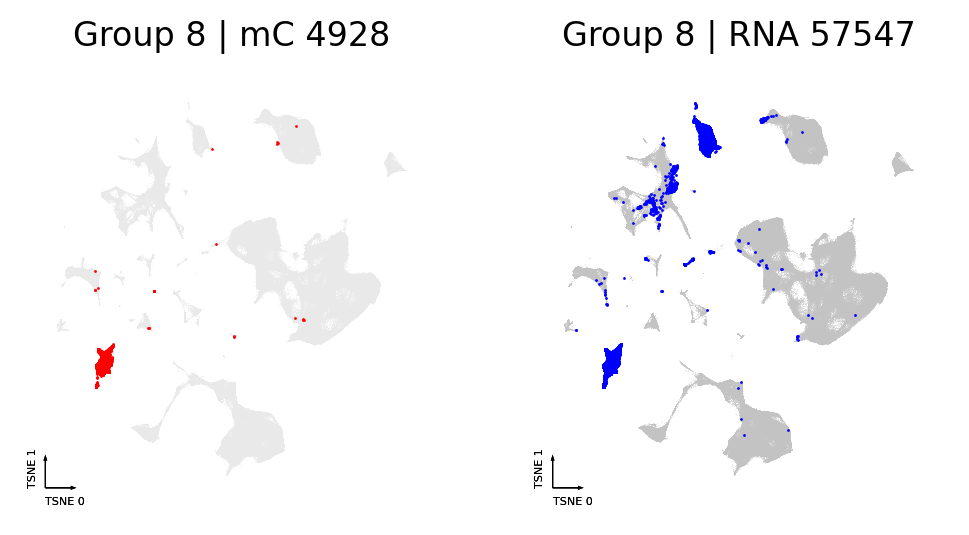

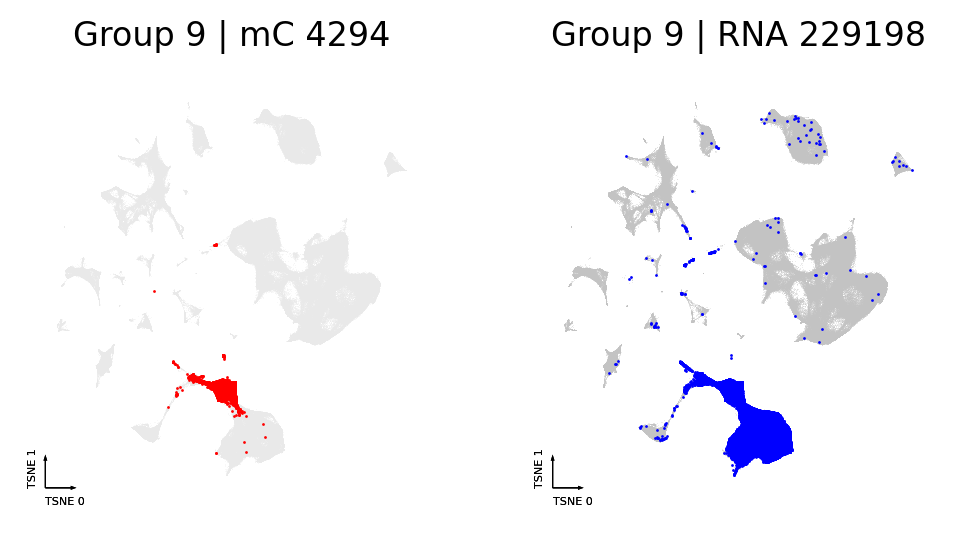

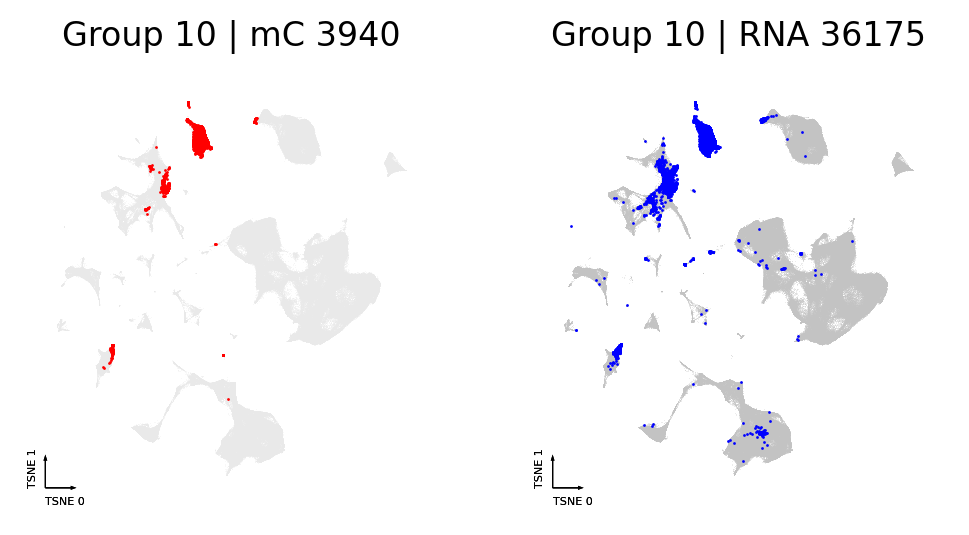

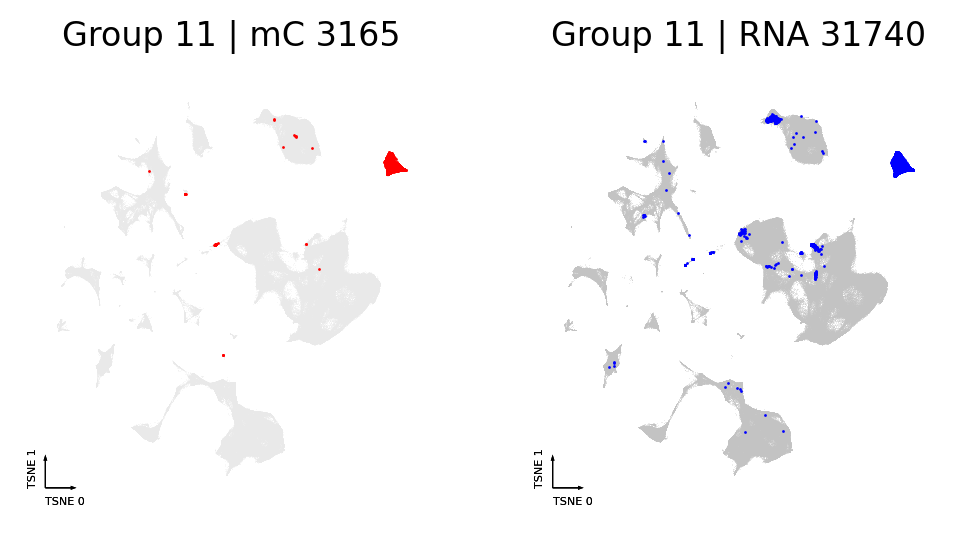

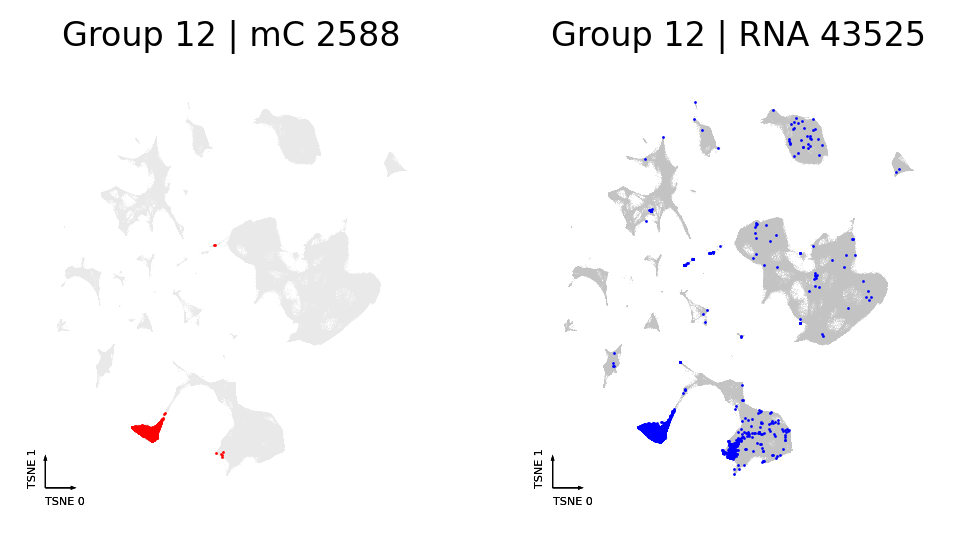

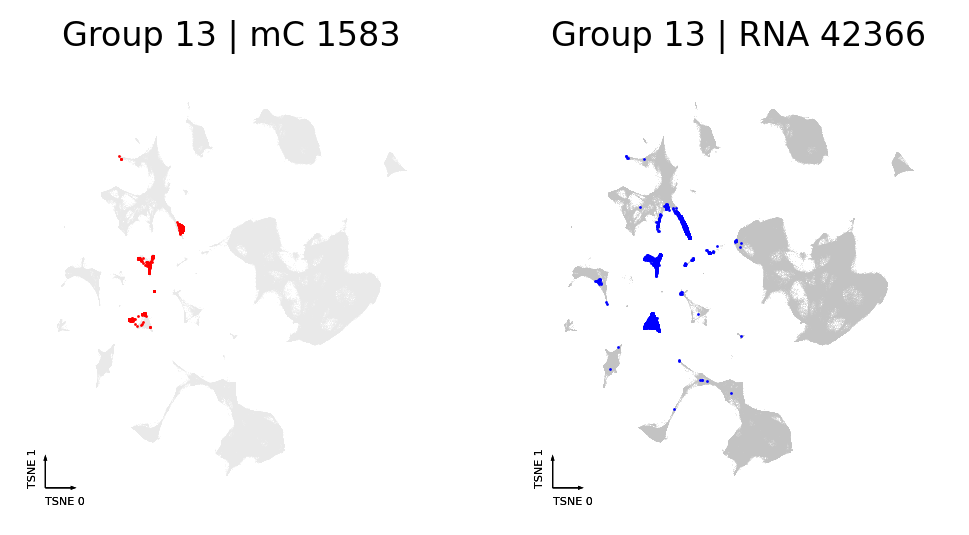

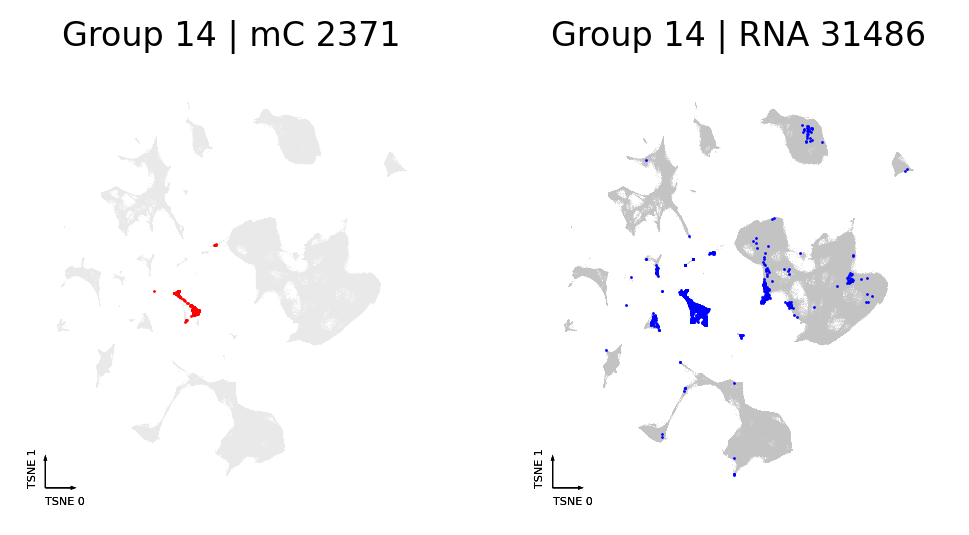

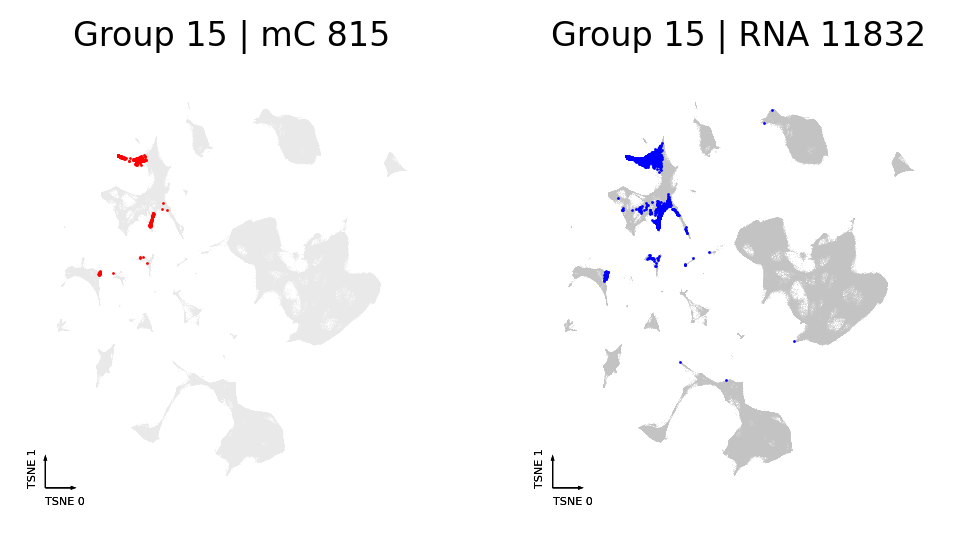

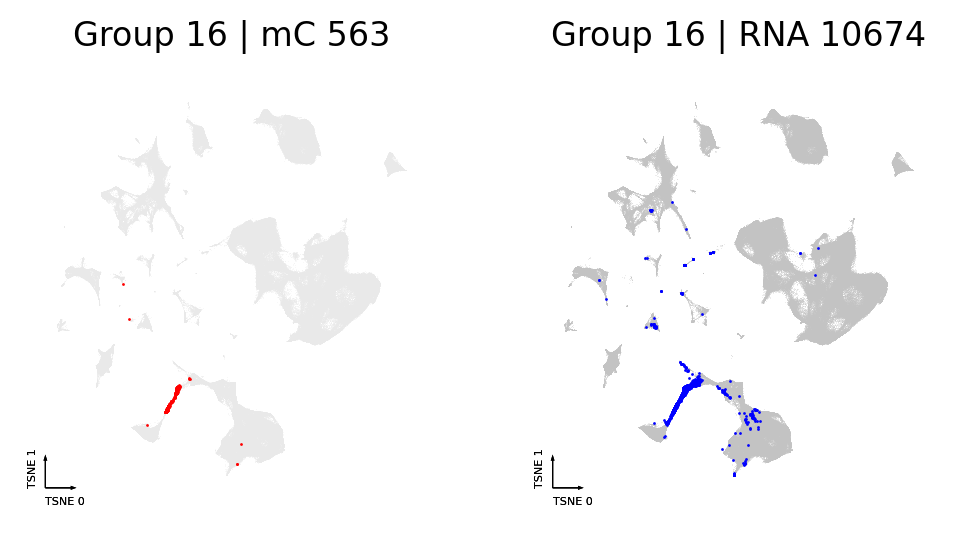

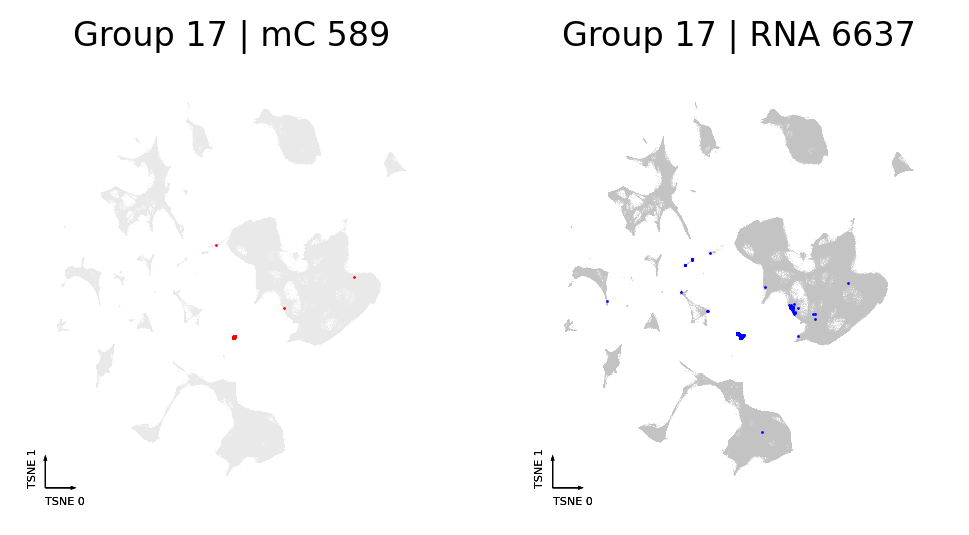

In [30]:
import matplotlib.backends.backend_pdf

adata = anndata.read_h5ad("final_with_coords.h5ad")

pdf = matplotlib.backends.backend_pdf.PdfPages("L3.integration_groups.pdf")

for i, (group, cluster_dict) in enumerate(integration_groups.items()):
    print(group)
    fig, axes = plt.subplots(
        figsize=(6, 3),
        nrows=1,
        ncols=2,
        dpi=200,
    )

    mc_cells = adata.obs["Modality"] == "mC"
    rna_cells = adata.obs["Modality"] == "RNA"
    use_mc_cells = mc_cluster[mc_cluster.isin(cluster_dict["ref"])].index
    use_rna_cells = rna_cluster[rna_cluster.isin(map(int, cluster_dict["query"]))].index

    ax = axes[0]
    categorical_scatter(
        ax=ax, data=adata, coord_base="tsne", color="lightgrey", max_points=None
    )
    categorical_scatter(
        ax=ax,
        s=1,
        data=adata[adata.obs_names.isin(use_mc_cells)],
        coord_base="tsne",
        color="red",
    )
    ax.set(title=f"Group {group} | mC {use_mc_cells.size}")
    ax = axes[1]
    categorical_scatter(
        ax=ax, data=adata[rna_cells], coord_base="tsne", color="grey", max_points=None
    )
    categorical_scatter(
        ax=ax,
        s=1,
        data=adata[adata.obs_names.isin(use_rna_cells)],
        coord_base="tsne",
        color="blue",
    )
    ax.set(title=f"Group {group} | RNA {use_rna_cells.size}")

    pdf.savefig(fig)
pdf.close()

In [32]:
import joblib

joblib.dump(
    integration_groups, f"RNA-{rna_cat_key}.mc-{mc_cat_key}.integration_groups.dict"
)

['RNA-L3.mc-L4Region.integration_groups.dict']